In [61]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

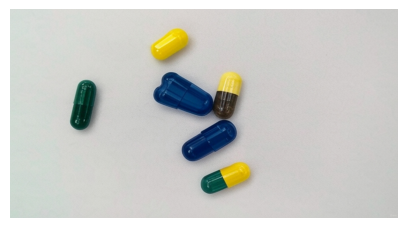

In [62]:
img = cv2.imread("/content/multiple_pill test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis(False)
plt.show()

# Thresholding
We will use thresholding to segment our images because of the white background.
Then, we will use the saturation model to get the mask as the background will be completely black in that model.

(See cell 3 for comparison)

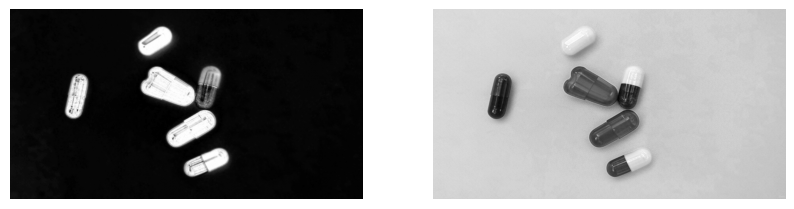

In [63]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
s = hsv[:,:,1]
v = hsv[:,:,2]

fig,axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(s, cmap="gray")
axs[1].imshow(v, cmap="gray")
axs[0].axis(False)
axs[1].axis(False)
plt.show()


Next, we will apply a gaussian blur so that the mask have smoother lines.
Then we perform 2 types of threshold- OTSU, and Binary. The Binary is simply for cases that the pill's saturation is close to that of the background. This will only get the pixels that are above 25 of value and raise it to 255.

Then we get the intersection of these masks to combine it to one

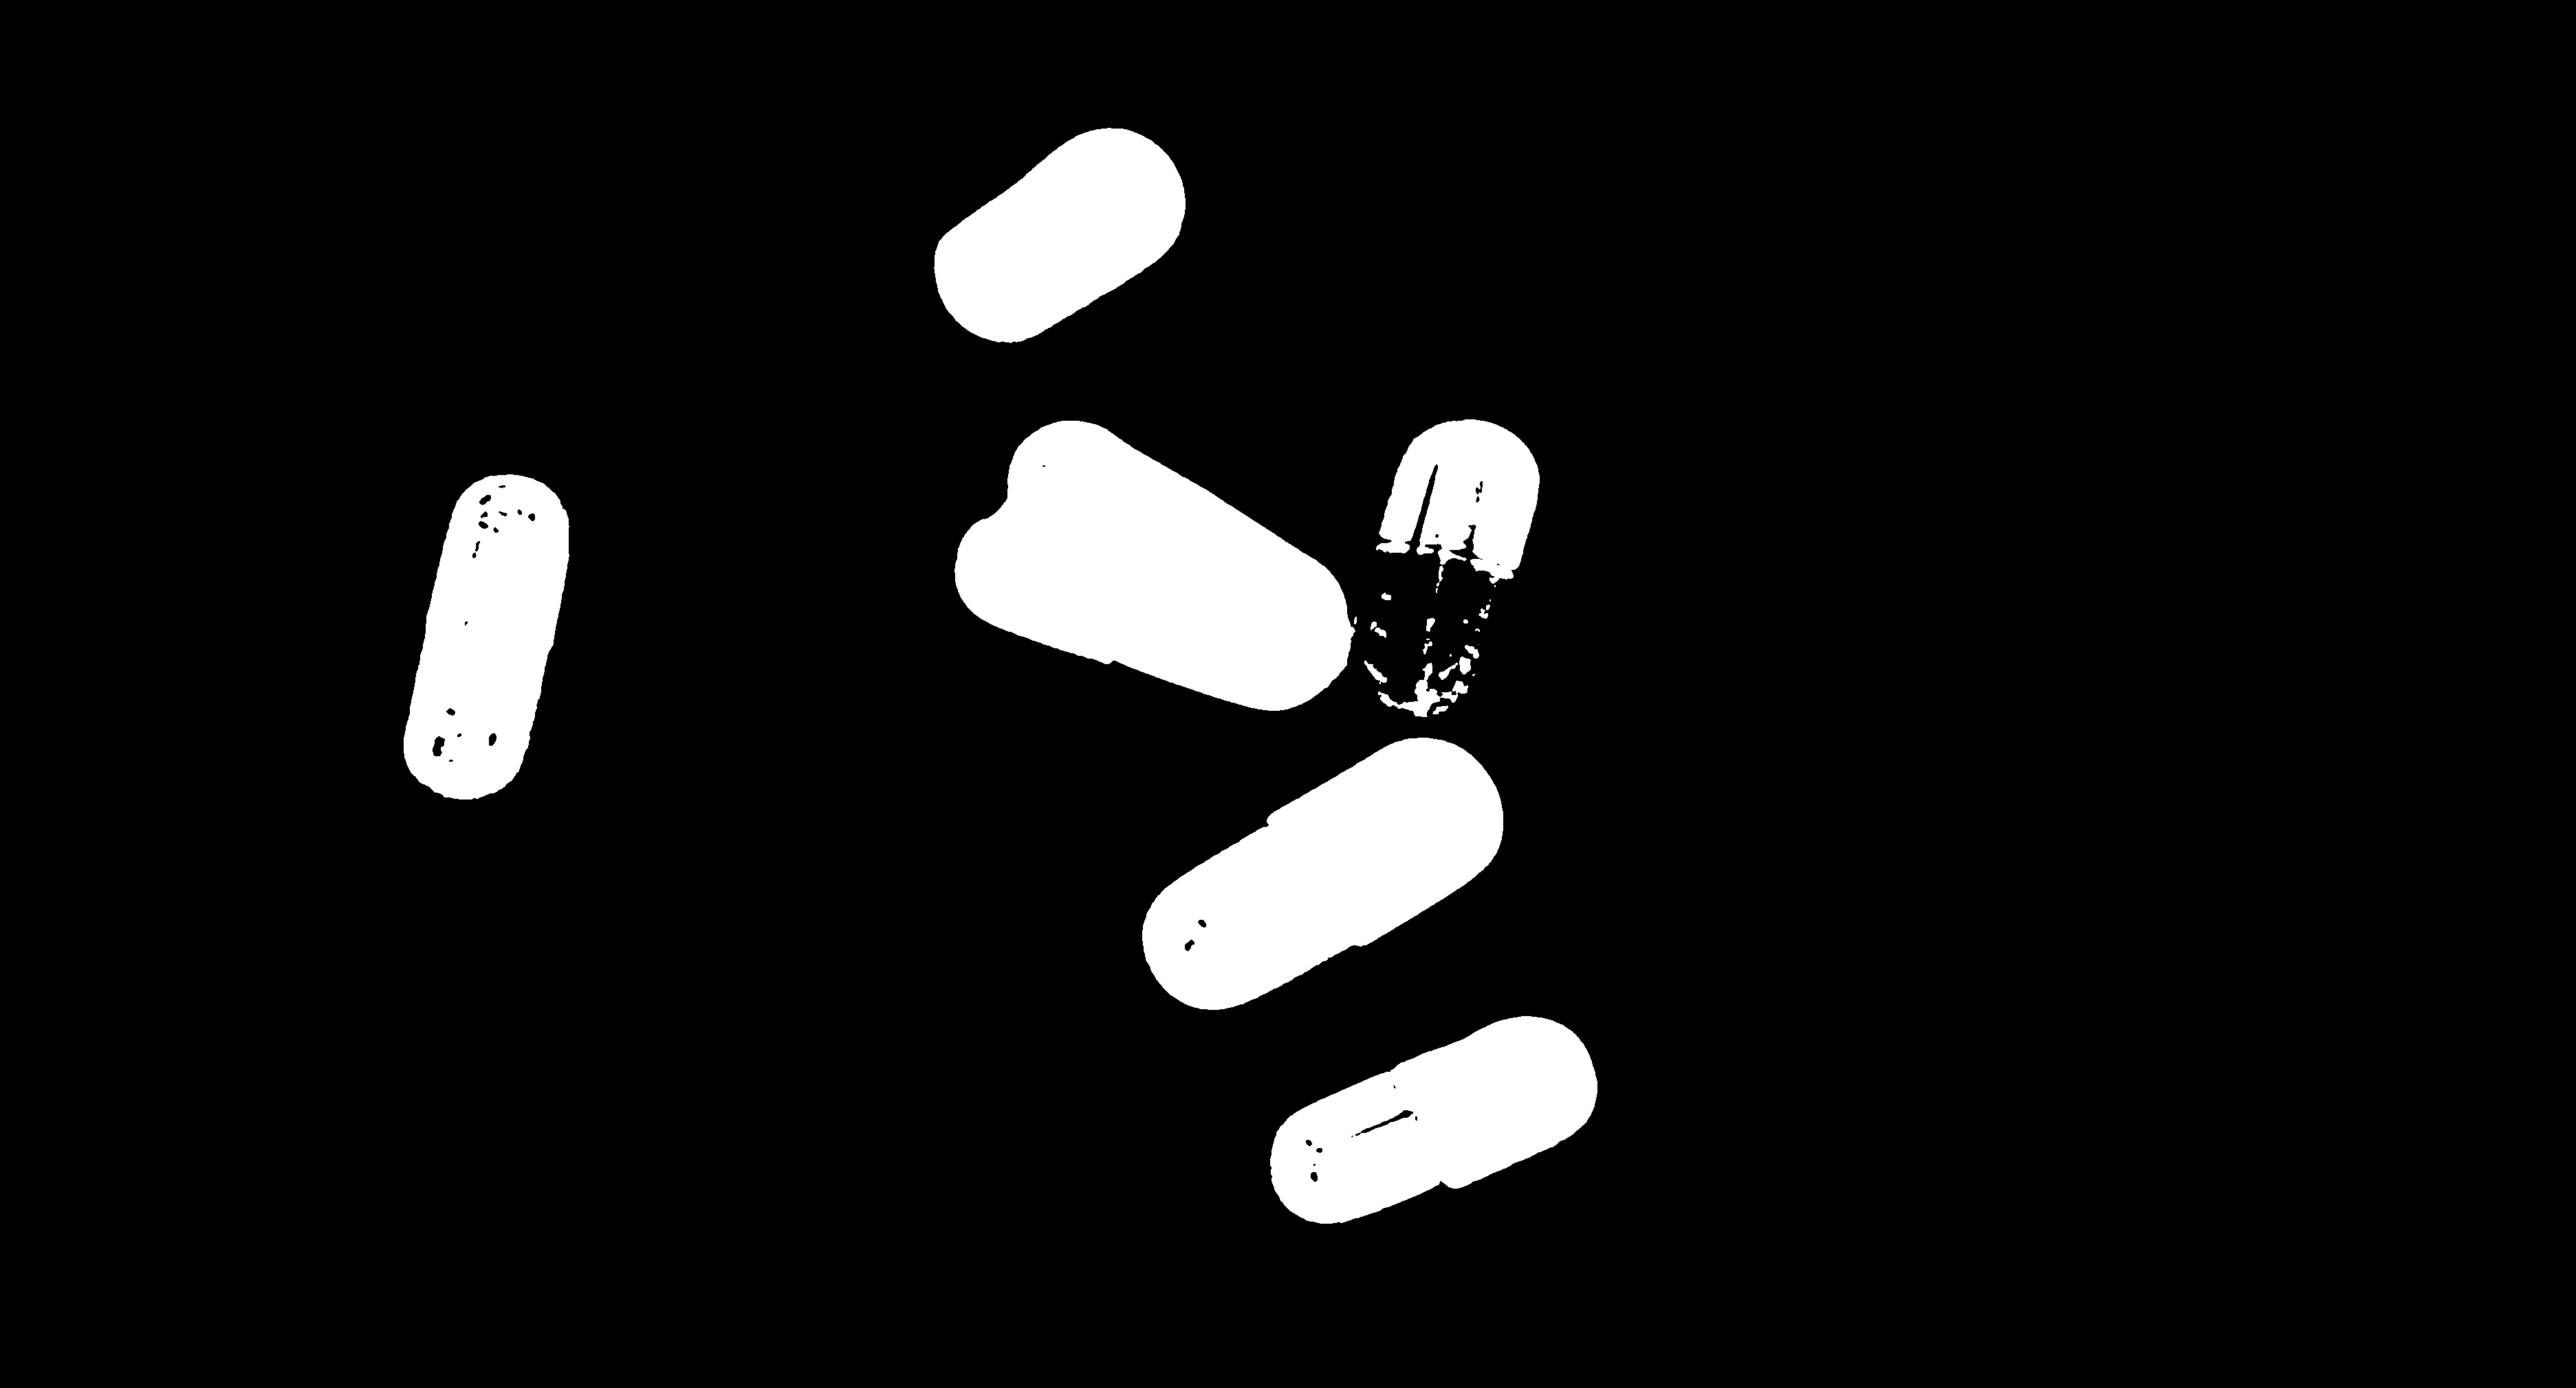

In [64]:
s_blur = cv2.GaussianBlur(s, (5,5), 0)
_, thresh1 = cv2.threshold(s_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh2 = cv2.threshold(s_blur, 25, 255, cv2.THRESH_BINARY)[1]

thresh = cv2.bitwise_and(thresh1, thresh2)
cv2_imshow(thresh)

Once the basic mask has been obtained, we will get the kernel for the large structures in the mask then apply morhpology to dilate necessary pixels or erod unecessary pixels.

This gives the cleaner mask where are are no isolated pixels or spots on the mask

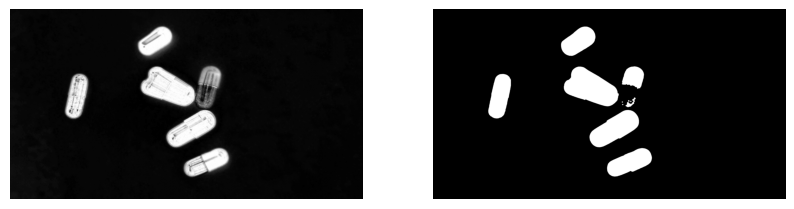

In [65]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(s_blur, cmap="gray")
axs[1].imshow(thresh, cmap="gray")
axs[0].axis(False)
axs[1].axis(False)
plt.show()

We get the contours to get all the shapes in the mask.
Create an empty mask of the same shape.

In [66]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(thresh.shape, dtype=np.uint8)

print(len(contours))

11


Set a minimum area of shapes to eliminate uneccesary shapes. Go over all the shapes and check against the minimum area

In [67]:
min_area = 300

valid_contours =[]
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > min_area:
        perimeter = cv2.arcLength(cnt, True)
        if perimeter > 0:
            circularity = 4 * np.pi * area / (perimeter ** 2)
            if circularity > 0.3:
                valid_contours.append(cnt)
                cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
print(len(valid_contours))

6


Apply one more dilation for clean up.

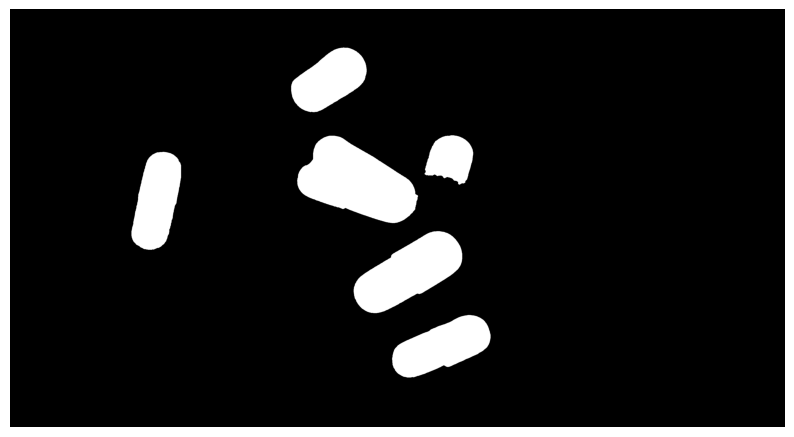

In [68]:
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_small, iterations=1)
mask = (mask > 0).astype(np.uint8) * 255

plt.figure(figsize=(10,10))
plt.imshow(mask, cmap="gray")
plt.axis(False)
plt.show()

Extract the pills from the image and save them as separate files

In [69]:
# os.makedirs("individual_pills_transparent", exist_ok=True)
extracted_pills=[]

for i, cnt in enumerate(valid_contours):
    single_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(single_mask, [cnt], -1, 255, thickness=cv2.FILLED)

    # Convert the RGB 'img' to BGRA directly for cv2.imwrite to save colors correctly
    pill_bgra = cv2.cvtColor(img, cv2.COLOR_RGB2BGRA)
    pill_bgra[:, :, 3] = single_mask

    x, y, w, h = cv2.boundingRect(cnt)
    cropped_pill = pill_bgra[y:y+h, x:x+w]

    transparent_path = f"individual_pills_transparent/pill_{i+1}.png"
    cv2.imwrite(transparent_path, cropped_pill)

    extracted_pills.append(cropped_pill)
    print(f"Pill {i+1} → saved (size: {w}x{h}, area: {int(cv2.contourArea(cnt))} px)")

Pill 1 → saved (size: 476x302, area: 86492 px)
Pill 2 → saved (size: 525x396, area: 115844 px)
Pill 3 → saved (size: 240x473, area: 79778 px)
Pill 4 → saved (size: 584x422, area: 149964 px)
Pill 5 → saved (size: 235x239, area: 39459 px)
Pill 6 → saved (size: 365x313, area: 72386 px)


(np.float64(-0.5), np.float64(3745.5), np.float64(2018.5), np.float64(-0.5))

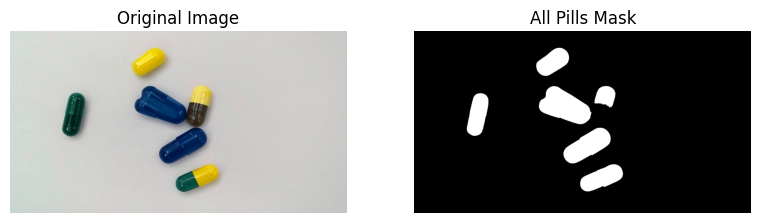

In [70]:
# Display Results
plt.figure(figsize=(20, 10))

# Show original
plt.subplot(2, 4, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

# Show full mask
full_mask = np.zeros(img.shape[:2], dtype=np.uint8)
for cnt in valid_contours:
    cv2.drawContours(full_mask, [cnt], -1, 255, -1)
plt.subplot(2, 4, 2)
plt.title("All Pills Mask")
plt.imshow(full_mask, cmap='gray')
plt.axis('off')
